In [1]:
# This is for accessing my google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# This code is for TPU usage in Colab 
%tensorflow_version 2.x
import tensorflow as tf
print("Tensorflow version " + tf.__version__)

try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
  raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy = tf.distribute.TPUStrategy(tpu)

In [3]:
import os
import numpy as np
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt
import cv2
import random
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D, Activation, MaxPooling2D, Dropout
from tensorflow.keras.layers import Conv2DTranspose, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
import math 

In [4]:
# check the number of data (high quality scans) and sort them
output = next(os.walk("/content/drive/My Drive/reduced_vs_thin_Al/Z 2/"))[2] 
print("No. of data = ", len(output))
output.sort()

No. of data =  1000


In [5]:
# High Quality Images 
folder = '/content/drive/My Drive/reduced_vs_thin_Al/Z 2'
high_quality = np.zeros(shape=(2000, 512, 512), dtype='uint16')

In [6]:
# import high quality images from the folder and take 2 random patches from each of them
for filename, i in zip(output, tqdm(range(1000))):
        im = Image.open(os.path.join(folder, filename))
        img = np.array(im)
        high_quality[i] = img[1000:1512, 1000:1512]
        high_quality[i + 1000] = img[1500:2012, 1500:2012]

100%|█████████▉| 999/1000 [18:11<00:00,  1.13it/s]

In [7]:
# check the number of data (low quality scans)
inputs = next(os.walk("/content/drive/My Drive/reduced_vs_thin_Al/Z 3"))[2] 
print("No. of data = ", len(inputs))
inputs.sort()  

No. of data =  1000


In [8]:
# Low Quality Images
folder = '/content/drive/My Drive/reduced_vs_thin_Al/Z 3'
low_quality = np.zeros(shape=(2000, 512, 512), dtype='uint16')

In [ ]:
# import low quality images from the folder and take 2 random patches from each of them
for filename, i in zip(inputs, tqdm(range(1000))):
        im = Image.open(os.path.join(folder, filename))
        img = np.array(im)
        low_quality[i] = img[1000:1512, 1000:1512]
        low_quality[i + 1000] = img[1500:2012, 1500:2012]

391


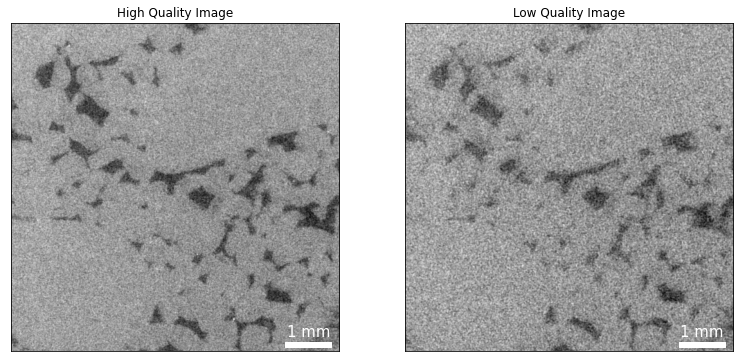

In [10]:
# Visualize a random pair from the training set (low_quality vs high quality)
ix = random.randint(0, len(high_quality))
print(ix)
plt.figure(figsize=(20,10))
plt.subplot(1,3,1), 
plt.title('High Quality Image')
plt.imshow(high_quality[ix], cmap='gray', extent=(0, 7.168, 0, 7.168))
plt.fill_between(x=[6.0, 7.0], y1=[0.1, 0.1], y2=[0.2, 0.2], color='white')
plt.text(x=6.50, y=0.25, s='1 mm', va='bottom', ha='center', color='white', size=15)
plt.xticks([]), plt.yticks([])
plt.subplot(1,3,2)
plt.title('Low Quality Image')
plt.imshow(low_quality[ix], cmap='gray', extent=(0, 7.168, 0, 7.168))
plt.fill_between(x=[6.0, 7.0], y1=[0.1, 0.1], y2=[0.2, 0.2], color='white')
plt.text(x=6.50, y=0.25, s='1 mm', va='bottom', ha='center', color='white', size=15)
plt.xticks([]), plt.yticks([])
plt.show()

In [11]:
# normalization of the labels (high_quality images)


#high_quality= high_quality / 65535
min_value = np.min(high_quality)
max_value = np.max(high_quality)
high_quality = (high_quality - min_value) / (max_value-min_value) 
#high_quality = high_quality.astype('float32')
#for i in range(len(high_quality)):
  #high_quality[i] = (high_quality[i] - np.min(high_quality[i])) / (np.max(high_quality[i]) - np.min(high_quality[i]))
#high_quality = high_quality.astype('float64')
#for i in range(len(high_quality)):
  #high_quality[i] = (high_quality[i] - np.mean(high_quality[i])) / (np.std(high_quality[i]))

#high_quality = (high_quality - np.mean(high_quality)) / np.std(high_quality)

In [12]:
# normalization of the inputs(low_quality images)


#low_quality = low_quality / 65535
min_value = np.min(low_quality)
max_value = np.max(low_quality)
low_quality = (low_quality - min_value) / (max_value-min_value) 
#low_quality = low_quality.astype('float32')
#for i in range(len(low_quality)):
  #low_quality[i] = (low_quality[i] - np.min(low_quality[i])) / (np.max(low_quality[i]) - np.min(low_quality[i]))
#low_quality = low_quality.astype('float64')
#for i in range(len(low_quality)):
  #low_quality[i] = (low_quality[i] - np.mean(low_quality[i])) / (np.std(low_quality[i]))
#low_quality = (low_quality - np.mean(low_quality)) / np.std(low_quality)

In [13]:
# Add the channel dimension before training
high_quality = high_quality.reshape(-1, 512, 512, 1 )
low_quality = low_quality.reshape(-1, 512, 512, 1)

In [14]:
# split the data into test and training according to the ratio of 20/80.
input_images_train, input_images_test, output_images_train, output_images_test = train_test_split(low_quality, high_quality, test_size=0.2, random_state=42)

In [15]:
initializer = 'he_normal'

In [16]:
def cnn(input_img):

  # Encoder Stage

  c1 = Conv2D(filters=32, kernel_size=(3, 3), \
               kernel_initializer= initializer , strides=(1,1), padding='same')(input_img)
  c1 = Activation('relu')(c1)

  c2 = Conv2D(filters=32, kernel_size=(3, 3), \
               kernel_initializer= initializer , strides=(1,1), padding='same')(c1)
  c2 = Activation('relu')(c2)

  #c3 = Conv2D(filters=32, kernel_size=(3, 3), \
               #kernel_initializer='he_uniform', strides=(1,1), padding='same')(c2)
  #c3 = Activation('relu')(c3)



  p1 = MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid')(c2)
  
  
  c4 = Conv2D(filters=64, kernel_size=(3, 3), \
               kernel_initializer=initializer , strides=(1,1), padding='same')(p1)
  c4 = Activation('relu')(c4)
  
  c5 = Conv2D(filters=64, kernel_size=(3, 3), \
               kernel_initializer=initializer , strides=(1,1), padding='same')(c4)
  c5 = Activation('relu')(c5)

  #c6 = Conv2D(filters=64, kernel_size=(3, 3), \
               #kernel_initializer='he_uniform', strides=(1,1), padding='same')(c5)
  #c6 = Activation('relu')(c6)


  
  p2 = MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid')(c5)
  
  
  
  
  
  c7 = Conv2D(filters=128, kernel_size=(3, 3), \
               kernel_initializer=initializer , strides=(1,1), padding='same')(p2)
  c7 = Activation('relu')(c7)
  
  c8 = Conv2D(filters=128, kernel_size=(3, 3), \
               kernel_initializer=initializer , strides=(1,1), padding='same')(c7)
  c8 = Activation('relu')(c8)  

  #c9 = Conv2D(filters=128, kernel_size=(3, 3), \
               #kernel_initializer='he_uniform', strides=(1,1), padding='same')(c8)
  #c9 = Activation('relu')(c9) 


  
  
  
  p3 = MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid')(c8)





  c10 = Conv2D(filters=256, kernel_size=(3, 3), \
               kernel_initializer=initializer , strides=(1,1), padding='same')(p3)
  c11 = Activation('relu')(c10)

  c12 = Conv2D(filters=256, kernel_size=(3, 3), \
               kernel_initializer=initializer , strides=(1,1), padding='same')(c11)
  c12 = Activation('relu')(c12) 

  #c13 = Conv2D(filters=256, kernel_size=(3, 3), \
               #kernel_initializer='he_uniform', strides=(1,1), padding='same')(c12)
  #c13 = Activation('relu')(c13) 

  d1 = Dropout(0.3)(c12)

  # Decoder Stage

  t1 = Conv2DTranspose(filters=128,kernel_size=(3,3), strides=(2, 2), padding='same')(d1)
  t1 = Activation('relu')(t1)
  concat_1 = concatenate([t1,c8])
  c14 = Conv2D(filters=128, kernel_size=(3, 3), \
               kernel_initializer=initializer , strides=(1,1), padding='same')(concat_1)
  c14 = Activation('relu')(c14)
  c15 = Conv2D(filters=128, kernel_size=(3, 3), \
               kernel_initializer=initializer , strides=(1,1), padding='same')(c14)
  c15 = Activation('relu')(c15)
  #c15 = Conv2D(filters=128, kernel_size=(3, 3), \
               #kernel_initializer='he_uniform', strides=(1,1), padding='same')(c15)
  #c15 = Activation('relu')(c15)


  t2 =  Conv2DTranspose(filters=64,kernel_size=(2,2), strides=(2, 2), padding='same')(c15)
  t2 = Activation('relu')(t2)
  concat_2 = concatenate([t2,c5])
  c16 = Conv2D(filters=64, kernel_size=(3, 3), \
               kernel_initializer=initializer , strides=(1,1), padding='same')(concat_2)
  c16 = Activation('relu')(c16)
  c17 = Conv2D(filters=64, kernel_size=(3, 3), \
               kernel_initializer=initializer , strides=(1,1), padding='same')(c16)
  c17 = Activation('relu')(c17)
  #c18 = Conv2D(filters=64, kernel_size=(3, 3), \
               #kernel_initializer='he_uniform', strides=(1,1), padding='same')(c17)
  #c18 = Activation('relu')(c18)



  t3 = Conv2DTranspose(filters=32,kernel_size=(2,2), strides=(2, 2), padding='same')(c17)
  t3 = Activation('relu')(t3)
  concat_3 = concatenate([t3,c2])
  c19 = Conv2D(filters=32, kernel_size=(3, 3), \
               kernel_initializer=initializer , strides=(1,1), padding='same')(concat_3)
  c19 = Activation('relu')(c19)
  c20 = Conv2D(filters=32, kernel_size=(3, 3), \
               kernel_initializer=initializer , strides=(1,1), padding='same')(c19)
  c20 = Activation('relu')(c20)
  #c21 = Conv2D(filters=32, kernel_size=(3, 3), \
               #kernel_initializer='he_uniform', strides=(1,1), padding='same')(c20)
  #c21 = Activation('relu')(c21)





  outputs = Conv2D(filters=1, kernel_size=(1, 1), \
               kernel_initializer=initializer , strides=(1,1), padding='same')(c20)
  model = Model(inputs=[input_img], outputs=[outputs])
  return model

In [17]:
def custom_loss(y_actual,y_pred):
    custom_loss= - (tf.image.ssim(y_actual, y_pred, 1))
    return custom_loss  

In [17]:
# compile model and determine the loss function
with tpu_strategy.scope():

  input_img = Input((512, 512, 1)) 
  model = cnn(input_img)


  model.compile(optimizer=Adam(learning_rate=0.0001), loss='mean_squared_error')
  #model.compile(optimizer=Adam(learning_rate=0.0001), loss=custom_loss)

  model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 512, 512, 32) 320         input_1[0][0]                    
__________________________________________________________________________________________________
activation (Activation)         (None, 512, 512, 32) 0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 512, 512, 32) 9248        activation[0][0]                 
______________________________________________________________________________________________

In [18]:
callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1)
] 

In [ ]:
training_results = model.fit(input_images_train, output_images_train, batch_size=16, epochs=100,\
                             validation_data=(input_images_test, output_images_test)) 

In [ ]:
# Plot the learning curve
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(training_results.history["loss"], label="loss")
plt.plot(training_results.history["val_loss"], label="val_loss")
plt.xlabel("Epochs")
plt.ylabel("loss")
plt.legend();

In [21]:
# Prediction
prediction = model.predict(input_images_test, verbose=1) 

13/13 [==============================] - 20s 2s/step


In [22]:
# random image from the test set
ix = random.randint(0, len(input_images_test))
print(ix)

300


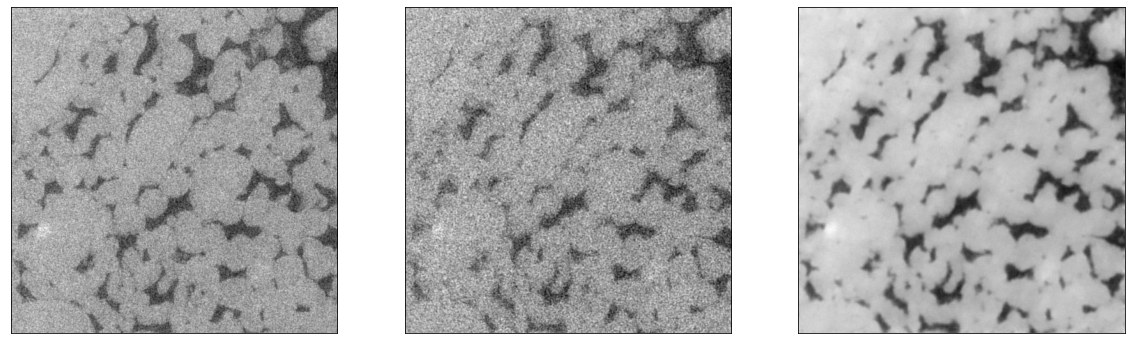

In [23]:
# Visualize any random test image along with the label and prediction
plt.figure(figsize=(20,6))
plt.subplot(1,3,1), 
plt.imshow(output_images_test[ix][:,:,0], cmap='gray'), 
#plt.title('High Quality Image')
plt.xticks([]), plt.yticks([])
plt.subplot(1,3,2),
plt.imshow(input_images_test[ix][:,:,0], cmap='gray'),
#plt.title('Reduced Time Exposure \n SSIM:%5.2f PSNR:%5.2f'%(S1,p1))
plt.xticks([]), plt.yticks([])
plt.subplot(1,3,3),
plt.imshow(prediction[ix][:,:,0], cmap='gray'),
#plt.title('Prediction \n SSIM:%5.2f PSNR:%5.2f'%(S2,p2))
plt.xticks([]), plt.yticks([])
plt.show()

In [24]:
# SSIM (Structural Similarity Index)
S1 = ssim(output_images_test[ix][:,:,0], input_images_test[ix][:,:,0], data_range=1,\
          gaussian_weights=True, sigma=1.5, use_sample_covariance=False)
S2 = ssim(output_images_test[ix][:,:,0], prediction[ix][:,:,0], data_range=1,\
          gaussian_weights=True, sigma=1.5, use_sample_covariance=False)
print('SSIM between the high_quality and low_quality image:%.5f'%(S1))
print('SSIM between the high_quality and denoised image:%.5f'%(S2))    

SSIM between the high_quality and low_quality image:0.53093
SSIM between the high_quality and denoised image:0.77680


In [27]:
# SSIM calculation for the test set before filtering
ssim_before_filtering = np.zeros(shape=(len(input_images_test),))
for i in range(len(input_images_test)):
  ssim_before_filtering[i] = ssim(output_images_test[i][:,:,0], input_images_test[i][:,:,0],\
                                  data_range=1,gaussian_weights=True,sigma=1.5,\
                                  use_sample_covariance=False) 

In [28]:
# SSIM calculation for the test set after filtering
ssim_after_filtering = np.zeros(shape=(len(input_images_test),))
for j in range(len(input_images_test)):
  ssim_after_filtering[j] = ssim(output_images_test[j][:,:,0], prediction[j][:,:,0],\
                                 data_range=1,gaussian_weights=True,sigma=1.5, \
                                 use_sample_covariance=False)

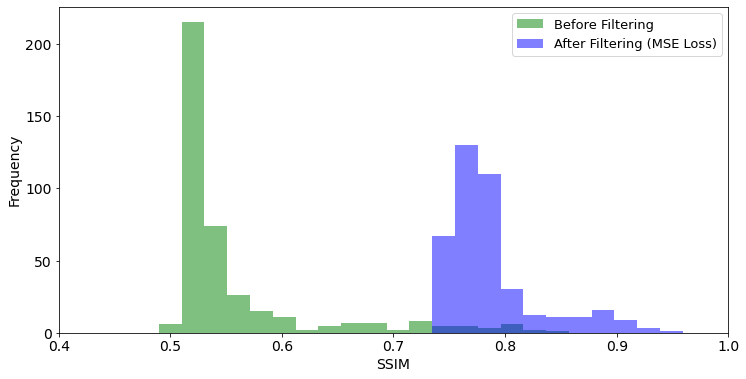

In [32]:
# SSIM HISTOGRAM
bins = np.linspace(0, 1, 50)
plt.figure(figsize=(12, 6))
plt.hist(ssim_before_filtering, bins, alpha=0.5, label='Before Filtering',color='green')
plt.hist(ssim_after_filtering, bins, alpha=0.5, label='After Filtering (MSE Loss)',color='blue')
plt.legend(loc='upper right', fontsize=13)
plt.xlabel("SSIM", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlim([0.40, 1.0])
plt.show()

In [33]:
# PSNR (Peak Signal to Noise Ratio)
P1 = psnr(output_images_test[ix][:,:,0], input_images_test[ix][:,:,0], data_range=1)
P2 = psnr(output_images_test[ix][:,:,0], prediction[ix][:,:,0], data_range=1)
print('PSNR between the high_quality and low_quality image:%.5f'%(P1))
print('PSNR between the high_quality and denoised image:%.5f'%(P2)) 

PSNR between the high_quality and low_quality image:22.76904
PSNR between the high_quality and denoised image:34.19094
